In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import DistilBertTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pickle

In [2]:
# Load dataset
data = pd.read_csv("../input/train-data/train_data.csv")
test_df = pd.read_csv("../input/test-data/test_data.csv")

data['text'] = data['title'] + " " + data['content_original']
test_df['text'] = test_df['title'] + " " + test_df['content_original']
data['text'] = data['text'].str.lower().fillna("")
test_df['text'] = test_df['text'].str.lower().fillna("")


In [3]:
# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['bias_text'])
test_df['label'] = label_encoder.transform(test_df['bias_text'])

In [4]:
# Save label encoder
with open("label_encoder.pkl", "wb") as le_file:
    pickle.dump(label_encoder, le_file)

In [5]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

In [6]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def encode_texts(texts, tokenizer, max_length=512):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="tf")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
# Tokenize text
X_train_enc = encode_texts(X_train, tokenizer)
X_val_enc = encode_texts(X_val, tokenizer)
X_test_enc = encode_texts(test_df['text'], tokenizer)

In [8]:
# Load DistilBERT model
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [9]:
# Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
history = model.fit(
    x={'input_ids': X_train_enc['input_ids'], 'attention_mask': X_train_enc['attention_mask']},
    y=y_train,
    validation_data=({'input_ids': X_val_enc['input_ids'], 'attention_mask': X_val_enc['attention_mask']}, y_val),
    epochs=5,
    batch_size=16,
    callbacks=[early_stop]
)

Epoch 1/5
1210/1210 [==============================] - 1369s 1s/step - loss: 0.5440 - accuracy: 0.7697 - val_loss: 0.3859 - val_accuracy: 0.8562
Epoch 2/5
1210/1210 [==============================] - 1348s 1s/step - loss: 0.2950 - accuracy: 0.8939 - val_loss: 0.3350 - val_accuracy: 0.8835
Epoch 3/5
1210/1210 [==============================] - 1345s 1s/step - loss: 0.1953 - accuracy: 0.9341 - val_loss: 0.3350 - val_accuracy: 0.8932
Epoch 4/5
1210/1210 [==============================] - 1343s 1s/step - loss: 0.1190 - accuracy: 0.9614 - val_loss: 0.4384 - val_accuracy: 0.8783
Epoch 5/5
1210/1210 [==============================] - 1347s 1s/step - loss: 0.0820 - accuracy: 0.9745 - val_loss: 0.4272 - val_accuracy: 0.8777


In [10]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(
    {'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']},
    test_df['label']
)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

189/189 [==============================] - 137s 724ms/step - loss: 0.1731 - accuracy: 0.9486
Test Loss: 0.17305415868759155
Test Accuracy: 0.9485780596733093


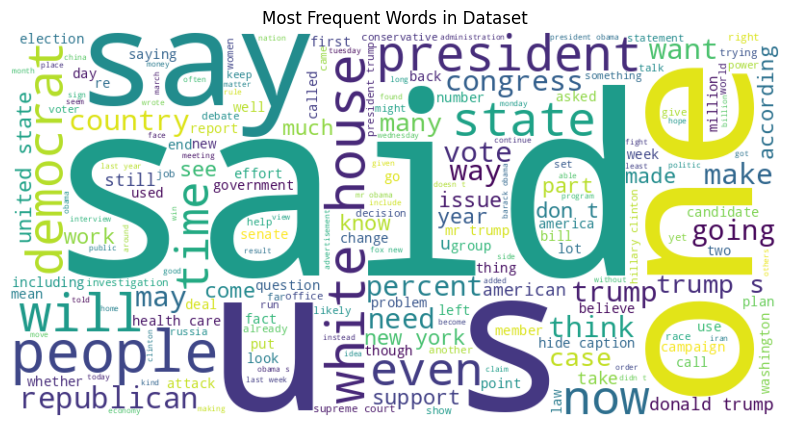

In [11]:
# Word Cloud
text = " ".join(data['text'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Dataset")
plt.show()

In [12]:
# Get raw logits
raw_predictions = model.predict({'input_ids': X_test_enc['input_ids'], 'attention_mask': X_test_enc['attention_mask']}).logits


189/189 [==============================] - 137s 722ms/step


In [13]:
# Convert logits to probabilities and get the predicted class
y_test_pred = np.argmax(tf.nn.softmax(raw_predictions).numpy(), axis=-1)

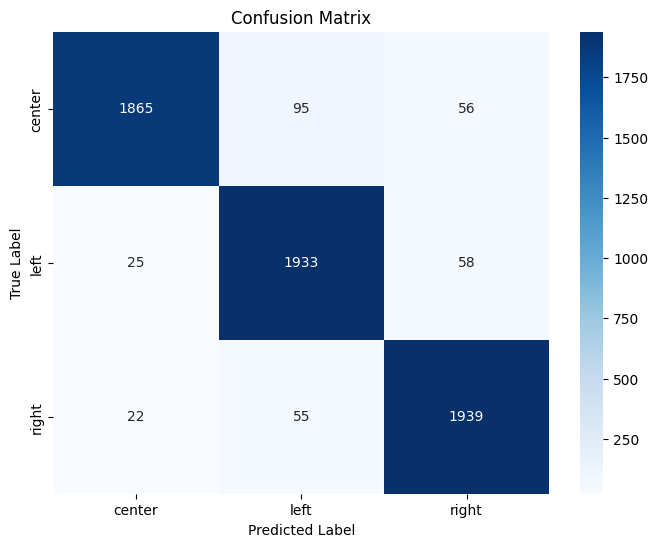

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_df['label'], y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

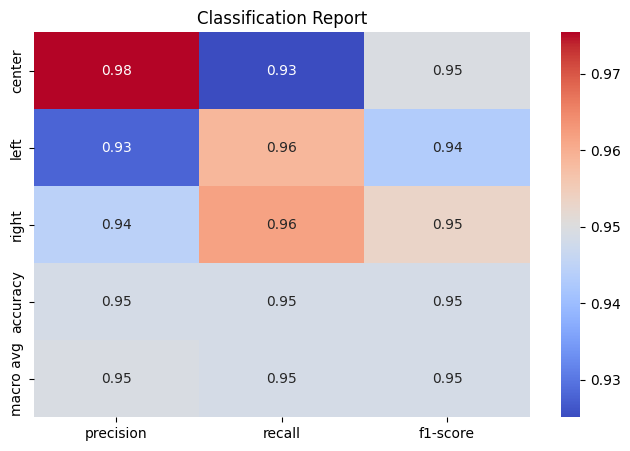

In [15]:
# Classification Report Heatmap
report_dict = classification_report(test_df['label'], y_test_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).T
plt.figure(figsize=(8, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Classification Report")
plt.show()

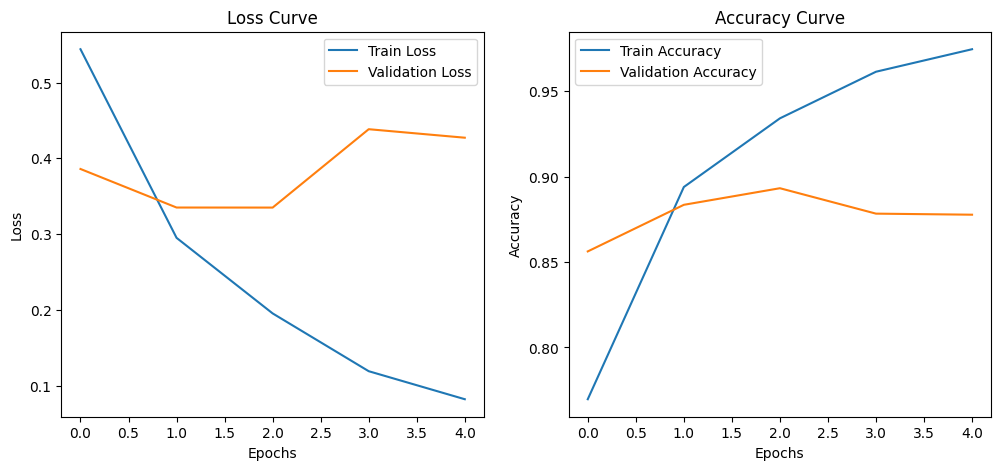

In [16]:
# Training History: Loss & Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


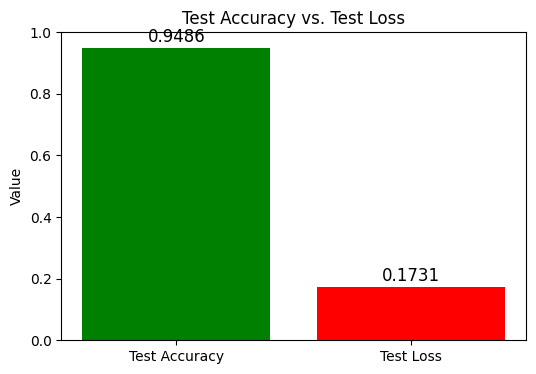

In [21]:
# Test metrics
metrics = ["Test Accuracy", "Test Loss"]
values = [test_accuracy, test_loss]

# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=["green", "red"])
plt.ylim(0, 1)  # Adjust y-axis to be between 0 and 1 for better comparison

# Add labels
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha="center", fontsize=12)

plt.ylabel("Value")
plt.title("Test Accuracy vs. Test Loss")
plt.show()

In [17]:
# Save the model
model.save_pretrained("distilbert_news_bias_model")
print("Model saved as 'distilbert_news_bias_model'")

Model saved as 'distilbert_news_bias_model'


In [18]:
# Load model for prediction
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert_news_bias_model")

def encode_texts(texts, tokenizer, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")


Some layers from the model checkpoint at distilbert_news_bias_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert_news_bias_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Predict new texts
new_texts = ["In a tweet on Wednesday night, Mr. Trump urged supporters to join him at a campaign rally..."]
new_enc = encode_texts(new_texts, tokenizer)  # FIXED: No need to call `.tolist()`
new_preds = np.argmax(model.predict({'input_ids': new_enc['input_ids'], 'attention_mask': new_enc['attention_mask']}).logits, axis=-1)
predicted_labels = label_encoder.inverse_transform(new_preds)

for text, label in zip(new_texts, predicted_labels):
    print(f"Text: {text}\nPredicted Bias: {label}\n")

1/1 [==============================] - 1s 1s/step
Text: In a tweet on Wednesday night, Mr. Trump urged supporters to join him at a campaign rally...
Predicted Bias: left

